# Dense vs Sparse GP Implementation Comparison

Comprehensive comparison of Dense (GPflow) vs Sparse (GPyTorch) GP implementations for graph-based kernels.

## Import Packages

In [1]:
%reload_ext autoreload
%autoreload 2

# Core imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
import time
import psutil
import os
import sys
import gc

# GP framework imports
import torch
import gpytorch
from gpytorch import settings as gsettings
from linear_operator import settings
import gpflow
import tensorflow as tf
from sklearn.metrics import mean_squared_error

# Set up paths and import custom kernels
project_root = '/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs'
sys.path.extend([project_root, 
                os.path.join(project_root, 'efficient_graph_gp'),
                os.path.join(project_root, 'efficient_graph_gp_sparse')])

from efficient_graph_gp.random_walk_samplers.sampler import RandomWalk as DenseRandomWalk, Graph as DenseGraph
from efficient_graph_gp_sparse.random_walk_samplers_sparse.sparse_sampler import SparseRandomWalk
from efficient_graph_gp.gpflow_kernels import GraphGeneralFastGRFKernel
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor

# Set seeds
torch.manual_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

## Exp Settings

In [ ]:
# EXPERIMENTAL CONFIGURATION PARAMETERS
# =====================================

# GPyTorch & Linear Operator settings
settings.verbose_linalg._default = False
settings._fast_covar_root_decomposition._default = False
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 53
gsettings.num_trace_samples._global_value = 64

# Random Walk Parameters
WALKS_PER_NODE = 1000
P_HALT = 0.1
MAX_WALK_LENGTH = 3
RW_MAX_WALK_LENGTH = 4  # For random walk comparison

# Graph sizes for random walk comparison
RW_GRAPH_SIZES = [
    {'nodes': 100, 'avg_degree': 8, 'walks': 100},
    {'nodes': 200, 'avg_degree': 10, 'walks': 100},
    {'nodes': 500, 'avg_degree': 15, 'walks': 50},
    {'nodes': 1000, 'avg_degree': 20, 'walks': 50},
    {'nodes': 2000, 'avg_degree': 25, 'walks': 30}
]

# Graph sizes for GP inference comparison
GP_GRAPH_SIZES = [10, 20, 40, 80, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]

# Training Parameters
N_EPOCHS = 50
TRAIN_RATIO = 0.6
NOISE_STD = 0.1 # Noise in synthetic data
INITIAL_NOISE_VARIANCE = 0.1
LEARNING_RATE = 0.1

# Random seeds
RANDOM_SEED = 1
BENCHMARK_RUNS = 3

print("✅ Experimental parameters configured")
print(f"Random walk params: {WALKS_PER_NODE} walks/node, p_halt={P_HALT}, max_length={MAX_WALK_LENGTH}")
print(f"GP training: {N_EPOCHS} epochs, train_ratio={TRAIN_RATIO}")
print(f"Graph sizes - RW: {[c['nodes'] for c in RW_GRAPH_SIZES]}, GP: {GP_GRAPH_SIZES}")

✅ Experimental parameters configured
Random walk params: 1000 walks/node, p_halt=0.1, max_length=3
GP training: 50 epochs, train_ratio=0.6
Graph sizes - RW: [100, 200, 500, 1000, 2000], GP: [10, 20, 40, 80, 100, 200, 400, 800, 1600]


## Random Walk Sampler Comparison

In [ ]:
def create_test_graph(n_nodes=50, avg_degree=4, seed=42):
    """Create random graph for testing"""
    np.random.seed(seed)
    p = avg_degree / (n_nodes - 1)
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).toarray().astype(float)
    return G, adj_matrix

def benchmark_sampler(sampler, num_walks, p_halt, max_walk_length, num_runs=3):
    """Benchmark random walk sampler performance"""
    times, memory_peaks, result = [], [], None
    
    for run in range(num_runs):
        gc.collect()
        time.sleep(0.1)
        
        mem_before = get_memory_usage()
        start_time = time.time()
        result = sampler.get_random_walk_matrices(num_walks, p_halt, max_walk_length)
        times.append(time.time() - start_time)
        memory_peaks.append(max(0, get_memory_usage() - mem_before))
        
        if run < num_runs - 1:
            del result
    
    return {
        'time': np.mean(times), 'time_std': np.std(times),
        'memory': np.mean(memory_peaks), 'memory_std': np.std(memory_peaks),
        'result': result
    }

# Run random walk comparison
rw_results = []
for config in RW_GRAPH_SIZES:
    print(f"Testing {config['nodes']} nodes...")
    
    G, adj_matrix = create_test_graph(config['nodes'], config['avg_degree'], seed=RANDOM_SEED)
    dense_sampler = DenseRandomWalk(DenseGraph(adj_matrix), seed=RANDOM_SEED)
    sparse_sampler = SparseRandomWalk(sp.csr_matrix(adj_matrix), seed=RANDOM_SEED)
    
    dense_result = benchmark_sampler(dense_sampler, config['walks'], P_HALT, RW_MAX_WALK_LENGTH, BENCHMARK_RUNS)
    sparse_result = benchmark_sampler(sparse_sampler, config['walks'], P_HALT, RW_MAX_WALK_LENGTH, BENCHMARK_RUNS)
    
    # Calculate metrics
    dense_obj_mb = dense_result['result'].nbytes / 1024**2
    sparse_obj_mb = sum(m.nnz for m in sparse_result['result']) * 16 / 1024**2
    
    rw_results.append({
        'nodes': config['nodes'], 'edges': G.number_of_edges(),
        'sparsity': G.number_of_edges() / (config['nodes'] ** 2),
        'dense_time': dense_result['time'], 'sparse_time': sparse_result['time'],
        'dense_memory': dense_result['memory'], 'sparse_memory': sparse_result['memory'],
        'dense_obj_mb': dense_obj_mb, 'sparse_obj_mb': sparse_obj_mb,
        'time_speedup': dense_result['time'] / sparse_result['time'],
        'memory_efficiency': dense_result['memory'] / sparse_result['memory'] if sparse_result['memory'] > 0 else np.inf,
        'obj_compression': dense_obj_mb / sparse_obj_mb if sparse_obj_mb > 0 else np.inf
    })

rw_df = pd.DataFrame(rw_results)
print(rw_df[['nodes', 'edges', 'time_speedup', 'memory_efficiency', 'obj_compression']].round(2))

## GP Inference Comparison

In [ ]:
def create_synthetic_dataset(n_nodes=100, train_ratio=0.6, noise_std=0.1):
    """Create synthetic cycle graph dataset"""
    G = nx.cycle_graph(n_nodes)  
    A = nx.adjacency_matrix(G).tocsr()
    
    # Generate smooth function
    angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
    y_true = 0.3*np.sin(2*angles) + 0.5*np.cos(4*angles)
    y_observed = y_true + np.random.normal(0, noise_std, n_nodes)
    
    # Create splits
    n_train = int(train_ratio * n_nodes)
    train_idx = np.random.choice(n_nodes, n_train, replace=False)
    test_idx = np.setdiff1d(np.arange(n_nodes), train_idx)
    
    return {
        'A_dense': A.toarray().astype(np.float64), 'A_sparse': A,
        'X_train': train_idx.reshape(-1, 1).astype(np.float64),
        'y_train': y_observed[train_idx].reshape(-1, 1),
        'X_test': test_idx.reshape(-1, 1).astype(np.float64),
        'y_test': y_observed[test_idx].reshape(-1, 1),
        'X_full': np.arange(n_nodes).reshape(-1, 1).astype(np.float64),
        'y_full': y_observed.reshape(-1, 1), 'y_true': y_true,
        'train_idx': train_idx, 'test_idx': test_idx
    }

class SparseGPModel(gpytorch.models.ExactGP):
    """Sparse GP model using GPyTorch with pathwise conditioning prediction"""
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.step_matrices_torch = step_matrices_torch
        self.covar_module = SparseGRFKernel( 
            max_walk_length=MAX_WALK_LENGTH, 
            step_matrices_torch=self.step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """
        Batch pathwise conditioning sampling.
        
        f_test_posterior = f_test_prior + K_test_train @ v
        v = (K_train_train + noise_variance*I)^{-1} @ (y_train - (f_train_prior + eps))
        f_test_prior and f_train_prior are jointly sampled from N(0, K)
        eps ~ N(0, noise_variance*I)
        
        Args:
            x_test (torch.Tensor): Test input locations (shape: [n_test, 1])
            n_samples (int): Number of samples to generate from the posterior
        """    
        from linear_operator.utils import linear_cg
        from linear_operator.operators import IdentityLinearOperator
        
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Get feature matrix and extract submatrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Precompute covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise parameters
        noise_variance = self.likelihood.noise.item()
        noise_std = np.sqrt(noise_variance)
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Generate batch random samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Batch compute prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # Batch compute RHS vectors
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        
        # Batched CG solve
        v_batch = linear_cg(
            matmul_closure=A._matmul,
            rhs=b_batch.T,
            tolerance=gsettings.cg_tolerance.value()
        )
        
        # Posterior samples at test inputs
        f_test_posterior_batch = f_test_prior_batch + (K_test_train @ v_batch).T

        return f_test_posterior_batch

def benchmark_gp_training(data, framework='dense', n_epochs=50):
    """Benchmark GP training with detailed timing"""
    mem_before = get_memory_usage()
    timing = {}
    
    if framework == 'dense':
        # GPflow dense implementation
        start_time = time.time()
        kernel = GraphGeneralFastGRFKernel(data['A_dense'], walks_per_node=WALKS_PER_NODE, p_halt=P_HALT, max_walk_length=MAX_WALK_LENGTH)
        model = gpflow.models.GPR(data=(data['X_train'], data['y_train']), kernel=kernel, noise_variance=INITIAL_NOISE_VARIANCE)
        timing['kernel_init'] = time.time() - start_time
        
        start_time = time.time()
        gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables, 
                                          options={'maxiter': n_epochs})
        timing['training'] = time.time() - start_time
        
        start_time = time.time()
        mean_pred, var_pred = model.predict_f(data['X_test'])
        mean_full, var_full = model.predict_f(data['X_full'])
        timing['inference'] = time.time() - start_time
        
        test_rmse = np.sqrt(mean_squared_error(data['y_test'], mean_pred.numpy()))
        train_ll = model.log_marginal_likelihood().numpy()
        
        predictions = {
            'test_mean': mean_pred.numpy().flatten(), 'test_std': np.sqrt(var_pred.numpy().flatten()),
            'full_mean': mean_full.numpy().flatten(), 'full_std': np.sqrt(var_full.numpy().flatten())
        }
        
        learned_params = {
            'noise_variance': float(model.likelihood.variance.numpy()),
            'modulator_vector': kernel.modulator_vector.numpy(),
        }
        
    else:
        # GPyTorch sparse implementation with pathwise conditioning
        start_time = time.time()
        
        # Preprocess graph using new preprocessor
        pp = GraphPreprocessor(
            adjacency_matrix=data['A_sparse'],
            walks_per_node=WALKS_PER_NODE,
            p_halt=P_HALT,
            max_walk_length=MAX_WALK_LENGTH,
            random_walk_seed=RANDOM_SEED,
            load_from_disk=False
        )
        step_matrices_torch = pp.preprocess_graph()
        
        # Convert data to torch tensors
        X_train_torch = torch.tensor(data['train_idx'], dtype=torch.float32).unsqueeze(1)
        y_train_torch = torch.tensor(data['y_train'].flatten(), dtype=torch.float32)
        X_test_torch = torch.tensor(data['test_idx'], dtype=torch.float32).unsqueeze(1)
        X_full_torch = torch.tensor(data['X_full'].flatten(), dtype=torch.float32).unsqueeze(1)
        
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = SparseGPModel(X_train_torch, y_train_torch, likelihood, step_matrices_torch)
        timing['kernel_init'] = time.time() - start_time
        
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        start_time = time.time()
        for i in range(n_epochs):
            optimizer.zero_grad()
            output = model(X_train_torch)
            loss = -mll(output, y_train_torch)
            loss.backward()
            optimizer.step()
        timing['training'] = time.time() - start_time
        
        model.eval()
        likelihood.eval()
        start_time = time.time()
        with torch.no_grad():
            # Use pathwise conditioning for predictions
            test_samples = model.predict(X_test_torch, n_samples=64)
            full_samples = model.predict(X_full_torch, n_samples=64)
            
            # Compute statistics from samples
            test_mean = test_samples.mean(dim=0)
            test_std = test_samples.std(dim=0)
            full_mean = full_samples.mean(dim=0)
            full_std = full_samples.std(dim=0)
        timing['inference'] = time.time() - start_time
        
        test_rmse = np.sqrt(mean_squared_error(data['y_test'], test_mean.numpy()))
        train_ll = -loss.item()
        
        predictions = {
            'test_mean': test_mean.numpy(), 'test_std': test_std.numpy(),
            'full_mean': full_mean.numpy(), 'full_std': full_std.numpy()
        }
        
        learned_params = {
            'noise_variance': float(model.likelihood.noise.item()),
            'modulator_vector': model.covar_module.modulator_vector.data.numpy().tolist()
        }
    return {
        'kernel_init_time': timing['kernel_init'], 'training_time': timing['training'],
        'inference_time': timing['inference'], 'total_time': sum(timing.values()),
        'memory_delta': get_memory_usage() - mem_before, 'test_rmse': test_rmse,
        'train_ll': train_ll, 'framework': framework, 'n_epochs': n_epochs,
        'predictions': predictions, 'learned_params': learned_params
    }

print("GP benchmark functions defined")

In [ ]:
# Run GP comparison
gp_configs = [{'nodes': nodes, 'train_ratio': TRAIN_RATIO} for nodes in GP_GRAPH_SIZES]

gp_results = []

for config in gp_configs:
    print(f"Testing GP inference on {config['nodes']} nodes...")
    
    np.random.seed(RANDOM_SEED)
    data = create_synthetic_dataset(config['nodes'], config['train_ratio'], NOISE_STD)
    
    dense_result = benchmark_gp_training(data, 'dense', N_EPOCHS)
    sparse_result = benchmark_gp_training(data, 'sparse', N_EPOCHS)
    
    result = {
        'nodes': config['nodes'], 'n_epochs': N_EPOCHS,
        # Timings
        'dense_kernel_init': dense_result['kernel_init_time'],
        'dense_training': dense_result['training_time'],
        'dense_inference': dense_result['inference_time'],
        'dense_total': dense_result['total_time'],
        'sparse_kernel_init': sparse_result['kernel_init_time'],
        'sparse_training': sparse_result['training_time'],
        'sparse_inference': sparse_result['inference_time'],
        'sparse_total': sparse_result['total_time'],
        # Performance
        'dense_memory': dense_result['memory_delta'],
        'sparse_memory': sparse_result['memory_delta'],
        'dense_rmse': dense_result['test_rmse'],
        'sparse_rmse': sparse_result['test_rmse'],
        'dense_ll': dense_result['train_ll'],
        'sparse_ll': sparse_result['train_ll'],
        # Speedups
        'kernel_speedup': dense_result['kernel_init_time'] / sparse_result['kernel_init_time'],
        'training_speedup': dense_result['training_time'] / sparse_result['training_time'],
        'inference_speedup': dense_result['inference_time'] / sparse_result['inference_time'],
        'total_speedup': dense_result['total_time'] / sparse_result['total_time'],
        'memory_efficiency': dense_result['memory_delta'] / sparse_result['memory_delta'] if sparse_result['memory_delta'] > 0 else np.inf
    }
    
    # Store detailed results for 50-node case
    if config['nodes'] == 50:
        result.update({
            'dense_predictions': dense_result['predictions'],
            'sparse_predictions': sparse_result['predictions'],
            'dense_params': dense_result['learned_params'],
            'sparse_params': sparse_result['learned_params'],
            'data': data
        })
    
    gp_results.append(result)
    
    print(f"  Dense:  {dense_result['total_time']:.3f}s total, RMSE={dense_result['test_rmse']:.4f}")
    print(f"  Sparse: {sparse_result['total_time']:.3f}s total, RMSE={sparse_result['test_rmse']:.4f}")

gp_df = pd.DataFrame(gp_results)
print(f"\nGP Comparison Results:")
print(gp_df[['nodes', 'total_speedup', 'training_speedup', 'dense_rmse', 'sparse_rmse']].round(3))

## Random Walk Plots

In [ ]:
# Random Walk Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Execution time comparison
axes[0,0].plot(rw_df['nodes'], rw_df['dense_time'], 'o-', label='Dense', linewidth=2, markersize=6)
axes[0,0].plot(rw_df['nodes'], rw_df['sparse_time'], 's-', label='Sparse', linewidth=2, markersize=6)
axes[0,0].set_xlabel('Number of Nodes')
axes[0,0].set_ylabel('Time (seconds)')
axes[0,0].set_title('Random Walk Execution Time')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_yscale('log')

# Speedup factor
axes[0,1].plot(rw_df['nodes'], rw_df['time_speedup'], 'ro-', linewidth=2, markersize=6)
axes[0,1].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No speedup')
axes[0,1].set_xlabel('Number of Nodes')
axes[0,1].set_ylabel('Speedup Factor')
axes[0,1].set_title('Random Walk Speedup (Dense/Sparse)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Memory usage comparison
axes[1,0].plot(rw_df['nodes'], rw_df['dense_obj_mb'], 'o-', label='Dense', linewidth=2, markersize=6)
axes[1,0].plot(rw_df['nodes'], rw_df['sparse_obj_mb'], 's-', label='Sparse', linewidth=2, markersize=6)
axes[1,0].set_xlabel('Number of Nodes')
axes[1,0].set_ylabel('Object Size (MB)')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Memory Usage Comparison')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Compression vs sparsity
axes[1,1].scatter(rw_df['sparsity'], rw_df['obj_compression'], s=80, alpha=0.7, c=rw_df['nodes'], cmap='viridis')
axes[1,1].set_xlabel('Graph Sparsity')
axes[1,1].set_ylabel('Object Compression Ratio')
axes[1,1].set_title('Compression vs Graph Sparsity')
axes[1,1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
cbar.set_label('Number of Nodes')

plt.suptitle('Random Walk Sampler Performance Analysis', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print(f"📊 Random Walk Summary:")
print(f"• Average speedup: {rw_df['time_speedup'].mean():.2f}x")
print(f"• Best speedup: {rw_df['time_speedup'].max():.2f}x at {rw_df.loc[rw_df['time_speedup'].idxmax(), 'nodes']} nodes")
print(f"• Average compression: {rw_df['obj_compression'].mean():.1f}x")

## GP Plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

# Ensure these exist
assert 'gp_df' in globals()
assert all(col in gp_df.columns for col in ['dense_kernel_init', 'dense_training', 'dense_inference',
                                            'sparse_kernel_init', 'sparse_training', 'sparse_inference',
                                            'dense_rmse', 'sparse_rmse', 'nodes'])

x_pos = np.arange(len(gp_df))
width = 0.35

def plot_timing_breakdown(category):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    dense_times = gp_df[f'dense_{category}']
    sparse_times = gp_df[f'sparse_{category}']
    
    ax.bar(x_pos - width/2, dense_times, width, label='Dense', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, sparse_times, width, label='Sparse', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'GP {category.replace("_", " ").title()} Time')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_rmse_comparison():
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.bar(x_pos - width/2, gp_df['dense_rmse'], width, label='Dense', alpha=0.8, color='skyblue')
    ax.bar(x_pos + width/2, gp_df['sparse_rmse'], width, label='Sparse', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Test RMSE')
    ax.set_title('Prediction Accuracy Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_stacked_timing():
    fig, ax = plt.subplots(figsize=(6, 6))

    # Stack values
    dense_stack = np.vstack([
        gp_df['dense_kernel_init'],
        gp_df['dense_training'],
        gp_df['dense_inference']
    ])
    sparse_stack = np.vstack([
        gp_df['sparse_kernel_init'],
        gp_df['sparse_training'],
        gp_df['sparse_inference']
    ])

    # Define better color scheme
    dense_colors = ['#add8e6', '#87ceeb', '#4682b4']      # light blue to darker blue
    sparse_colors = ['#f4cccc', '#ea9999', '#cc0000']     # light red to darker red
    labels = ['Init', 'Training', 'Inference']

    # Plot Dense
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        ax.bar(x_pos - width/2, dense_stack[i], width, 
               label=f'Dense {labels[i]}', bottom=bottom,
               color=dense_colors[i], edgecolor='black', linewidth=0.5)
        bottom += dense_stack[i]

    # Plot Sparse
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        ax.bar(x_pos + width/2, sparse_stack[i], width, 
               label=f'Sparse {labels[i]}', bottom=bottom,
               color=sparse_colors[i], edgecolor='black', linewidth=0.5)
        bottom += sparse_stack[i]

    ax.set_xlabel('Graph Size (nodes)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Stacked GP Timings: Init, Training, Inference')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{n}" for n in gp_df['nodes']])
    ax.legend(ncol=2)
    ax.grid(True, alpha=0.3)
    plt.show()


# Interactive selector
@interact(view=[
    'Kernel Init Time', 
    'Training Time', 
    'Inference Time', 
    'Stacked Timing', 
    'RMSE Comparison'
])
def display_plot(view):
    if view == 'Kernel Init Time':
        plot_timing_breakdown('kernel_init')
    elif view == 'Training Time':
        plot_timing_breakdown('training')
    elif view == 'Inference Time':
        plot_timing_breakdown('inference')
    elif view == 'Stacked Timing':
        plot_stacked_timing()
    elif view == 'RMSE Comparison':
        plot_rmse_comparison()


## Save the data to csv file

In [7]:
# Saving the data & plots
import os
from datetime import datetime
import pickle

# Create results directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(project_root, 'experiments_sparse', 'results', f'comparison_{timestamp}')
os.makedirs(results_dir, exist_ok=True)

def save_results(results_dir, rw_df, gp_df, gp_results):
    """Save all experimental results to disk"""
    
    # Save CSV files
    rw_df.to_csv(os.path.join(results_dir, 'random_walk_comparison.csv'), index=False)
    gp_df.to_csv(os.path.join(results_dir, 'gp_comparison.csv'), index=False)
    
    # Save detailed GP results as pickle (includes predictions and parameters)
    with open(os.path.join(results_dir, 'gp_detailed_results.pkl'), 'wb') as f:
        pickle.dump(gp_results, f)
    
    # Save experimental configuration
    config = {
        'WALKS_PER_NODE': WALKS_PER_NODE,
        'P_HALT': P_HALT,
        'MAX_WALK_LENGTH': MAX_WALK_LENGTH,
        'N_EPOCHS': N_EPOCHS,
        'TRAIN_RATIO': TRAIN_RATIO,
        'NOISE_STD': NOISE_STD,
        'LEARNING_RATE': LEARNING_RATE,
        'RANDOM_SEED': RANDOM_SEED,
        'GP_GRAPH_SIZES': GP_GRAPH_SIZES,
        'RW_GRAPH_SIZES': RW_GRAPH_SIZES
    }
    
    with open(os.path.join(results_dir, 'config.pkl'), 'wb') as f:
        pickle.dump(config, f)
    
    print(f"✅ Results saved to: {results_dir}")
    return results_dir

def load_results(results_dir):
    """Load experimental results from disk"""
    
    # Load CSV files
    rw_df = pd.read_csv(os.path.join(results_dir, 'random_walk_comparison.csv'))
    gp_df = pd.read_csv(os.path.join(results_dir, 'gp_comparison.csv'))
    
    # Load detailed results
    with open(os.path.join(results_dir, 'gp_detailed_results.pkl'), 'rb') as f:
        gp_results = pickle.load(f)
    
    # Load configuration
    with open(os.path.join(results_dir, 'config.pkl'), 'rb') as f:
        config = pickle.load(f)
    
    print(f"✅ Results loaded from: {results_dir}")
    return rw_df, gp_df, gp_results, config

def save_plots(results_dir, rw_df, gp_df, gp_results):
    """Save all plots to disk"""
    
    # Random Walk Performance Plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Execution time comparison
    axes[0,0].plot(rw_df['nodes'], rw_df['dense_time'], 'o-', label='Dense', linewidth=2, markersize=6)
    axes[0,0].plot(rw_df['nodes'], rw_df['sparse_time'], 's-', label='Sparse', linewidth=2, markersize=6)
    axes[0,0].set_xlabel('Number of Nodes')
    axes[0,0].set_ylabel('Time (seconds)')
    axes[0,0].set_title('Random Walk Execution Time')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')
    
    # Speedup factor
    axes[0,1].plot(rw_df['nodes'], rw_df['time_speedup'], 'ro-', linewidth=2, markersize=6)
    axes[0,1].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No speedup')
    axes[0,1].set_xlabel('Number of Nodes')
    axes[0,1].set_ylabel('Speedup Factor')
    axes[0,1].set_title('Random Walk Speedup (Dense/Sparse)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Memory usage comparison
    axes[1,0].plot(rw_df['nodes'], rw_df['dense_obj_mb'], 'o-', label='Dense', linewidth=2, markersize=6)
    axes[1,0].plot(rw_df['nodes'], rw_df['sparse_obj_mb'], 's-', label='Sparse', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('Number of Nodes')
    axes[1,0].set_ylabel('Object Size (MB)')
    axes[1,0].set_yscale('log')
    axes[1,0].set_title('Memory Usage Comparison')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Compression vs sparsity
    axes[1,1].scatter(rw_df['sparsity'], rw_df['obj_compression'], s=80, alpha=0.7, c=rw_df['nodes'], cmap='viridis')
    axes[1,1].set_xlabel('Graph Sparsity')
    axes[1,1].set_ylabel('Object Compression Ratio')
    axes[1,1].set_title('Compression vs Graph Sparsity')
    axes[1,1].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
    cbar.set_label('Number of Nodes')
    
    plt.suptitle('Random Walk Sampler Performance Analysis', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'random_walk_performance.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # GP Training Performance Plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    x_pos = np.arange(len(gp_df))
    width = 0.35
    
    # Stacked timing
    dense_stack = np.vstack([gp_df['dense_kernel_init'], gp_df['dense_training'], gp_df['dense_inference']])
    sparse_stack = np.vstack([gp_df['sparse_kernel_init'], gp_df['sparse_training'], gp_df['sparse_inference']])
    
    dense_colors = ['#add8e6', '#87ceeb', '#4682b4']
    sparse_colors = ['#f4cccc', '#ea9999', '#cc0000']
    labels = ['Init', 'Training', 'Inference']
    
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        axes[0,0].bar(x_pos - width/2, dense_stack[i], width, 
                     label=f'Dense {labels[i]}', bottom=bottom,
                     color=dense_colors[i], edgecolor='black', linewidth=0.5)
        bottom += dense_stack[i]
    
    bottom = np.zeros(len(gp_df))
    for i in range(3):
        axes[0,0].bar(x_pos + width/2, sparse_stack[i], width, 
                     label=f'Sparse {labels[i]}', bottom=bottom,
                     color=sparse_colors[i], edgecolor='black', linewidth=0.5)
        bottom += sparse_stack[i]
    
    axes[0,0].set_xlabel('Graph Size (nodes)')
    axes[0,0].set_ylabel('Time (seconds)')
    axes[0,0].set_title('Stacked GP Timings: Init, Training, Inference')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels([f"{n}" for n in gp_df['nodes']])
    axes[0,0].legend(ncol=2)
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    axes[0,1].bar(x_pos - width/2, gp_df['dense_rmse'], width, label='Dense', alpha=0.8, color='skyblue')
    axes[0,1].bar(x_pos + width/2, gp_df['sparse_rmse'], width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[0,1].set_xlabel('Graph Size (nodes)')
    axes[0,1].set_ylabel('Test RMSE')
    axes[0,1].set_title('Prediction Accuracy Comparison')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels([f"{n}" for n in gp_df['nodes']])
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Speedup trends
    axes[1,0].plot(gp_df['nodes'], gp_df['total_speedup'], 'go-', label='Total Speedup', linewidth=2, markersize=6)
    axes[1,0].plot(gp_df['nodes'], gp_df['training_speedup'], 'bo-', label='Training Speedup', linewidth=2, markersize=6)
    axes[1,0].plot(gp_df['nodes'], gp_df['inference_speedup'], 'ro-', label='Inference Speedup', linewidth=2, markersize=6)
    axes[1,0].axhline(y=1, color='k', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('Graph Size (nodes)')
    axes[1,0].set_ylabel('Speedup Factor')
    axes[1,0].set_title('GP Performance Speedup Trends')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xscale('log')
    
    # Summary statistics
    axes[1,1].axis('off')
    summary_text = f"""
GP Comparison Summary:
• Total Speedup: {gp_df['total_speedup'].mean():.2f}x (avg)
• Training Speedup: {gp_df['training_speedup'].mean():.2f}x (avg)
• Inference Speedup: {gp_df['inference_speedup'].mean():.2f}x (avg)
• RMSE Difference: {abs(gp_df['sparse_rmse'] - gp_df['dense_rmse']).mean():.4f} (avg)

Random Walk Summary:
• Time Speedup: {rw_df['time_speedup'].mean():.2f}x (avg)
• Memory Compression: {rw_df['obj_compression'].mean():.1f}x (avg)
• Best Performance: {rw_df['time_speedup'].max():.2f}x speedup

Configuration:
• Walks per node: {WALKS_PER_NODE}
• Max walk length: {MAX_WALK_LENGTH}
• Training epochs: {N_EPOCHS}
• Learning rate: {LEARNING_RATE}
"""
    axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.suptitle('GP Training Performance Analysis', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'gp_performance.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # GP Inference Example (if 50-node case exists)
    if any(result.get('dense_predictions') for result in gp_results):
        result_50 = next(result for result in gp_results if result.get('dense_predictions'))
        data_50 = result_50['data']
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Dense predictions
        axes[0,0].scatter(data_50['train_idx'], data_50['y_train'].flatten(), c='blue', alpha=0.8, s=40, label='Train', zorder=3)
        axes[0,0].scatter(data_50['test_idx'], data_50['y_test'].flatten(), c='red', alpha=0.8, s=40, label='Test', zorder=3)
        axes[0,0].plot(range(len(data_50['y_true'])), data_50['y_true'], 'k--', linewidth=2.5, label='True function', zorder=2)
        axes[0,0].plot(range(len(data_50['y_true'])), result_50['dense_predictions']['full_mean'], 'g-', linewidth=2.5, label='GP mean', zorder=2)
        axes[0,0].fill_between(range(len(data_50['y_true'])), 
                            result_50['dense_predictions']['full_mean'] - 2*result_50['dense_predictions']['full_std'],
                            result_50['dense_predictions']['full_mean'] + 2*result_50['dense_predictions']['full_std'],
                            alpha=0.3, color='green', label='95% CI', zorder=1)
        axes[0,0].set_xlabel('Node index')
        axes[0,0].set_ylabel('Function value')
        axes[0,0].set_title(f'Dense GP (GPflow) - RMSE: {result_50["dense_rmse"]:.4f}')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Sparse predictions
        axes[0,1].scatter(data_50['train_idx'], data_50['y_train'].flatten(), c='blue', alpha=0.8, s=40, label='Train', zorder=3)
        axes[0,1].scatter(data_50['test_idx'], data_50['y_test'].flatten(), c='red', alpha=0.8, s=40, label='Test', zorder=3)
        axes[0,1].plot(range(len(data_50['y_true'])), data_50['y_true'], 'k--', linewidth=2.5, label='True function', zorder=2)
        axes[0,1].plot(range(len(data_50['y_true'])), result_50['sparse_predictions']['full_mean'], 'purple', linewidth=2.5, label='GP mean', zorder=2)
        axes[0,1].fill_between(range(len(data_50['y_true'])), 
                            result_50['sparse_predictions']['full_mean'] - 2*result_50['sparse_predictions']['full_std'],
                            result_50['sparse_predictions']['full_mean'] + 2*result_50['sparse_predictions']['full_std'],
                            alpha=0.3, color='purple', label='95% CI', zorder=1)
        axes[0,1].set_xlabel('Node index')
        axes[0,1].set_ylabel('Function value')
        axes[0,1].set_title(f'Sparse GP (GPyTorch) - RMSE: {result_50["sparse_rmse"]:.4f}')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Hyperparameter comparison
        dense_params = result_50['dense_params']
        sparse_params = result_50['sparse_params']
        
        dense_mod = dense_params['modulator_vector']
        sparse_mod = sparse_params['modulator_vector']
        
        x_mod = np.arange(len(dense_mod))
        width = 0.35
        
        axes[1,0].bar(x_mod - width/2, dense_mod, width, label='Dense', alpha=0.8, color='skyblue')
        axes[1,0].bar(x_mod + width/2, sparse_mod, width, label='Sparse', alpha=0.8, color='lightcoral')
        axes[1,0].set_xlabel('Walk Step')
        axes[1,0].set_ylabel('Modulator Weight')
        axes[1,0].set_title('Learned Modulator Vectors')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xticks(x_mod)
        
        # Hyperparameter table
        axes[1,1].axis('off')
        table_data = [
            ['Parameter', 'Dense (GPflow)', 'Sparse (GPyTorch)'],
            ['Noise Variance', f'{dense_params["noise_variance"]:.2e}', f'{sparse_params["noise_variance"]:.4f}'],
            ['Modulator L2', f'{np.linalg.norm(dense_mod):.3f}', f'{np.linalg.norm(sparse_mod):.3f}'],
            ['RMSE', f'{result_50["dense_rmse"]:.4f}', f'{result_50["sparse_rmse"]:.4f}'],
            ['Log Likelihood', f'{result_50["dense_ll"]:.2f}', f'{result_50["sparse_ll"]:.2f}']
        ]
        
        table = axes[1,1].table(cellText=table_data[1:], colLabels=table_data[0], 
                               cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.5)
        
        for i in range(len(table_data)):
            for j in range(len(table_data[0])):
                cell = table[(i, j)] if i == 0 else table[(i-1, j)]
                if i == 0:
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        axes[1,1].set_title('Hyperparameter Comparison', pad=20, fontsize=12, weight='bold')
        
        plt.suptitle('GP Inference Example', fontsize=14, y=0.95)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, 'gp_inference_example.png'), dpi=300, bbox_inches='tight')
        plt.close()
    print(f"✅ Plots saved to: {results_dir}")

In [ ]:
# # Save current results
# if 'rw_df' in globals() and 'gp_df' in globals():
#     saved_dir = save_results(results_dir, rw_df, gp_df, gp_results)
#     save_plots(results_dir, rw_df, gp_df, gp_results)
#     print(f"\n📁 All results saved to: {saved_dir}")
# else:
#     print("⚠️ No experimental data found to save. Run experiments first.")

## Visual from Disk Data

🎨 Creating focused visualizations from saved data...
📊 Loading results from: /Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments_sparse/results/comparison_20250803_154613
✅ Results loaded from: /Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments_sparse/results/comparison_20250803_154613


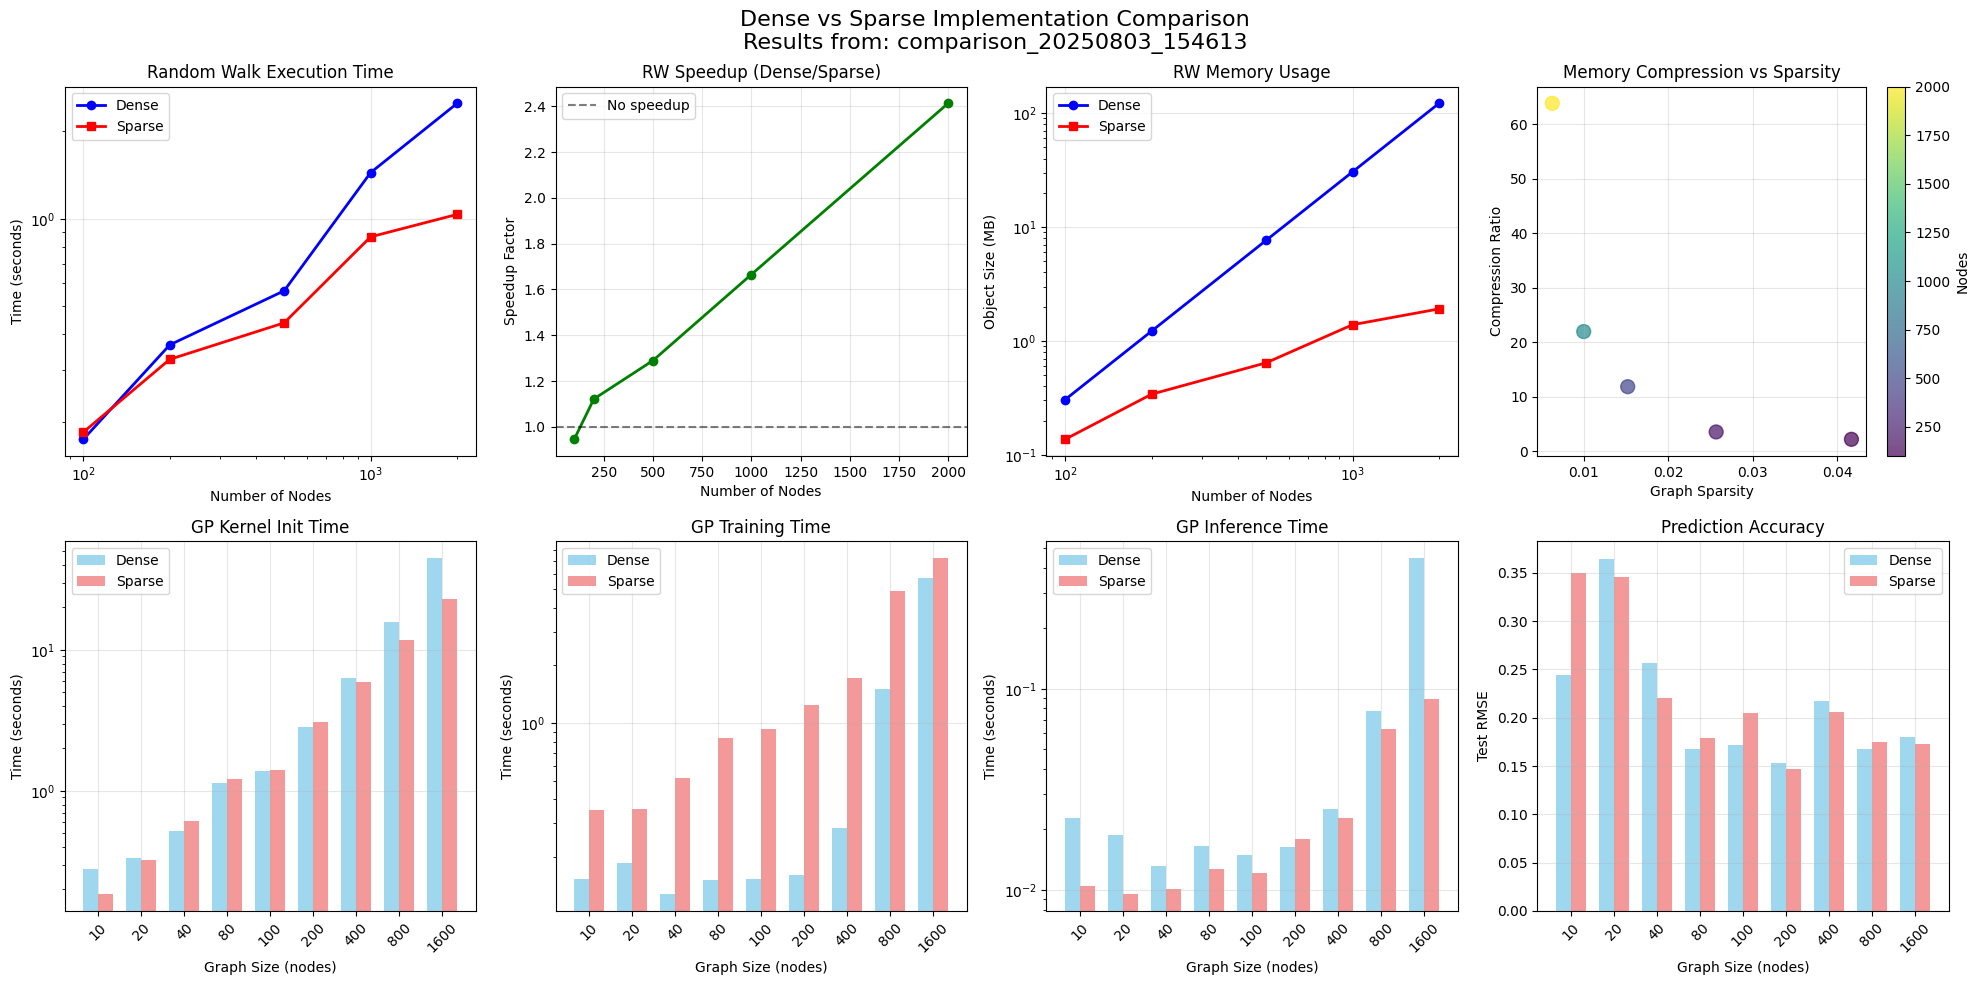


PERFORMANCE SUMMARY

📊 Random Walk Performance:
   • Average Speedup: 1.49x
   • Best Speedup: 2.41x (at 2000 nodes)
   • Average Memory Compression: 20.7x

🚀 GP Performance:
   • Init Speedup: 1.18x (average)
   • Training Speedup: 0.33x (average)
   • Inference Speedup: 1.81x (average)
   • RMSE Difference: 0.0263 (|sparse - dense| average)

⚙️ Configuration:
   • Walks per Node: 1000
   • Max Walk Length: 3
   • Training Epochs: 50
   • Graph Sizes: 9 sizes from 10 to 1600 nodes

📊 Random Walk Results (5 graph sizes):
   nodes  edges  time_speedup  memory_efficiency  obj_compression
0    100    417         0.945              0.139            2.231
1    200   1027         1.122              1.745            3.583
2    500   3800         1.289              2.751           11.886
3   1000   9987         1.665              0.426           21.998
4   2000  25069         2.413              3.336           63.872

🚀 GP Results (9 graph sizes):
   nodes  dense_kernel_init  sparse_kernel_in

In [ ]:
# ===============================================================================
# VISUALIZATION FROM SAVED DATA
# ===============================================================================

def find_latest_results():
    """Find the most recent results directory"""
    results_base = os.path.join(project_root, 'experiments_sparse', 'results')
    if not os.path.exists(results_base):
        return None
    
    dirs = [d for d in os.listdir(results_base) if d.startswith('comparison_')]
    if not dirs:
        return None
    
    latest = sorted(dirs)[-1]
    return os.path.join(results_base, latest)

def visualize_saved_results(results_path=None):
    """Create focused visualizations from saved results"""
    
    # Load data
    if results_path is None:
        results_path = find_latest_results()
        if not results_path:
            print("❌ No saved results found. Run experiments first.")
            return
    
    print(f"📊 Loading results from: {results_path}")
    rw_df_viz, gp_df_viz, gp_results_viz, config_viz = load_results(results_path)
    
    # Create focused visualization with 2x4 layout
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # ===== TOP ROW: RANDOM WALK ANALYSIS =====
    
    # RW Plot 1: Execution time comparison
    axes[0,0].loglog(rw_df_viz['nodes'], rw_df_viz['dense_time'], 'o-', label='Dense', linewidth=2, markersize=6, color='blue')
    axes[0,0].loglog(rw_df_viz['nodes'], rw_df_viz['sparse_time'], 's-', label='Sparse', linewidth=2, markersize=6, color='red')
    axes[0,0].set_xlabel('Number of Nodes')
    axes[0,0].set_ylabel('Time (seconds)')
    axes[0,0].set_title('Random Walk Execution Time')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RW Plot 2: Speedup factor
    axes[0,1].plot(rw_df_viz['nodes'], rw_df_viz['time_speedup'], 'go-', linewidth=2, markersize=6)
    axes[0,1].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No speedup')
    axes[0,1].set_xlabel('Number of Nodes')
    axes[0,1].set_ylabel('Speedup Factor')
    axes[0,1].set_title('RW Speedup (Dense/Sparse)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # RW Plot 3: Memory usage comparison
    axes[0,2].loglog(rw_df_viz['nodes'], rw_df_viz['dense_obj_mb'], 'o-', label='Dense', linewidth=2, color='blue')
    axes[0,2].loglog(rw_df_viz['nodes'], rw_df_viz['sparse_obj_mb'], 's-', label='Sparse', linewidth=2, color='red')
    axes[0,2].set_xlabel('Number of Nodes')
    axes[0,2].set_ylabel('Object Size (MB)')
    axes[0,2].set_title('RW Memory Usage')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # RW Plot 4: Compression vs sparsity
    scatter = axes[0,3].scatter(rw_df_viz['sparsity'], rw_df_viz['obj_compression'], 
                               s=100, alpha=0.7, c=rw_df_viz['nodes'], cmap='viridis')
    axes[0,3].set_xlabel('Graph Sparsity')
    axes[0,3].set_ylabel('Compression Ratio')
    axes[0,3].set_title('Memory Compression vs Sparsity')
    plt.colorbar(scatter, ax=axes[0,3], label='Nodes')
    axes[0,3].grid(True, alpha=0.3)
    
    # ===== BOTTOM ROW: GP PERFORMANCE ANALYSIS =====
    x_pos = np.arange(len(gp_df_viz))
    width = 0.35
    
    # GP Plot 1: Init time
    axes[1,0].bar(x_pos - width/2, gp_df_viz['dense_kernel_init'], width, label='Dense', alpha=0.8, color='skyblue')
    axes[1,0].bar(x_pos + width/2, gp_df_viz['sparse_kernel_init'], width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Graph Size (nodes)')
    axes[1,0].set_ylabel('Time (seconds)')
    axes[1,0].set_title('GP Kernel Init Time')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels([f"{n}" for n in gp_df_viz['nodes']], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_yscale('log')
    
    # GP Plot 2: Training time
    axes[1,1].bar(x_pos - width/2, gp_df_viz['dense_training'], width, label='Dense', alpha=0.8, color='skyblue')
    axes[1,1].bar(x_pos + width/2, gp_df_viz['sparse_training'], width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[1,1].set_xlabel('Graph Size (nodes)')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].set_title('GP Training Time')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels([f"{n}" for n in gp_df_viz['nodes']], rotation=45)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_yscale('log')
    
    # GP Plot 3: Inference time
    axes[1,2].bar(x_pos - width/2, gp_df_viz['dense_inference'], width, label='Dense', alpha=0.8, color='skyblue')
    axes[1,2].bar(x_pos + width/2, gp_df_viz['sparse_inference'], width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[1,2].set_xlabel('Graph Size (nodes)')
    axes[1,2].set_ylabel('Time (seconds)')
    axes[1,2].set_title('GP Inference Time')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels([f"{n}" for n in gp_df_viz['nodes']], rotation=45)
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    axes[1,2].set_yscale('log')
    
    # GP Plot 4: Prediction accuracy (RMSE)
    axes[1,3].bar(x_pos - width/2, gp_df_viz['dense_rmse'], width, label='Dense', alpha=0.8, color='skyblue')
    axes[1,3].bar(x_pos + width/2, gp_df_viz['sparse_rmse'], width, label='Sparse', alpha=0.8, color='lightcoral')
    axes[1,3].set_xlabel('Graph Size (nodes)')
    axes[1,3].set_ylabel('Test RMSE')
    axes[1,3].set_title('Prediction Accuracy')
    axes[1,3].set_xticks(x_pos)
    axes[1,3].set_xticklabels([f"{n}" for n in gp_df_viz['nodes']], rotation=45)
    axes[1,3].legend()
    axes[1,3].grid(True, alpha=0.3)
    
    plt.suptitle(f'Dense vs Sparse Implementation Comparison\nResults from: {os.path.basename(results_path)}', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY")
    print("="*80)
    
    # Random Walk Summary
    rw_avg_speedup = rw_df_viz['time_speedup'].mean()
    rw_best_speedup = rw_df_viz['time_speedup'].max()
    rw_avg_compression = rw_df_viz['obj_compression'].mean()
    
    print(f"\n📊 Random Walk Performance:")
    print(f"   • Average Speedup: {rw_avg_speedup:.2f}x")
    print(f"   • Best Speedup: {rw_best_speedup:.2f}x (at {rw_df_viz.loc[rw_df_viz['time_speedup'].idxmax(), 'nodes']} nodes)")
    print(f"   • Average Memory Compression: {rw_avg_compression:.1f}x")
    
    # GP Summary
    gp_avg_init_speedup = (gp_df_viz['dense_kernel_init'] / gp_df_viz['sparse_kernel_init']).mean()
    gp_avg_train_speedup = (gp_df_viz['dense_training'] / gp_df_viz['sparse_training']).mean()
    gp_avg_inference_speedup = (gp_df_viz['dense_inference'] / gp_df_viz['sparse_inference']).mean()
    gp_rmse_diff = abs(gp_df_viz['sparse_rmse'] - gp_df_viz['dense_rmse']).mean()
    
    print(f"\n🚀 GP Performance:")
    print(f"   • Init Speedup: {gp_avg_init_speedup:.2f}x (average)")
    print(f"   • Training Speedup: {gp_avg_train_speedup:.2f}x (average)")
    print(f"   • Inference Speedup: {gp_avg_inference_speedup:.2f}x (average)")
    print(f"   • RMSE Difference: {gp_rmse_diff:.4f} (|sparse - dense| average)")
    
    print(f"\n⚙️ Configuration:")
    print(f"   • Walks per Node: {config_viz['WALKS_PER_NODE']}")
    print(f"   • Max Walk Length: {config_viz['MAX_WALK_LENGTH']}")
    print(f"   • Training Epochs: {config_viz['N_EPOCHS']}")
    print(f"   • Graph Sizes: {len(gp_df_viz)} sizes from {gp_df_viz['nodes'].min()} to {gp_df_viz['nodes'].max()} nodes")
    
    # Print detailed tables
    print(f"\n📊 Random Walk Results ({len(rw_df_viz)} graph sizes):")
    print(rw_df_viz[['nodes', 'edges', 'time_speedup', 'memory_efficiency', 'obj_compression']].round(3))
    
    print(f"\n🚀 GP Results ({len(gp_df_viz)} graph sizes):")
    gp_summary = gp_df_viz[['nodes', 'dense_kernel_init', 'sparse_kernel_init', 'dense_training', 'sparse_training', 
                           'dense_inference', 'sparse_inference', 'dense_rmse', 'sparse_rmse']].round(3)
    print(gp_summary)
    
    return rw_df_viz, gp_df_viz, gp_results_viz, config_viz

# Run visualization
print("🎨 Creating focused visualizations from saved data...")
loaded_data = visualize_saved_results()

if loaded_data:
    rw_df_loaded, gp_df_loaded, gp_results_loaded, config_loaded = loaded_data
    print(f"\n✅ Visualization complete! Data from {len(gp_results_loaded)} experiments loaded.")